In [1]:
import os
import copy
import time
import pickle
import numpy as np
import yaml
from tqdm import tqdm

import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F

from generate_synthetic import generate_synthetic, train_val_dataloader

torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

In [2]:
config = dict()
config['local_batch_size'] = 10
config['local_iters'] = 1           # E
config['global_iters'] = 200         # T

config['num_devices'] = 30           # p
config['num_active_devices'] = 10

config['lr'] = 0.01
config['num_classes'] = 10
config['device'] = 'cuda:0'

config['iid'] = 0
config['alpha'] = 0.5
config['beta'] = 0.75

config['gamma'] = 0.5
config['dimension'] = 60

config_path = '../config/synthetic_iid.yaml' 
with open(config_path, 'w') as f:
    yaml.dump(config, f)

In [3]:
with open(config_path, 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
    print(config)

{'alpha': 0.75, 'beta': 0.75, 'device': 'cuda:0', 'dimension': 60, 'gamma': 0.5, 'global_iters': 200, 'iid': 0, 'local_batch_size': 10, 'local_iters': 1, 'lr': 0.01, 'num_active_devices': 10, 'num_classes': 10, 'num_devices': 30}


In [4]:
# define training model
class MLP(nn.Module):
    def __init__(self, dim_in, dim_out):
        super(MLP, self).__init__()
        self.layer_hidden = nn.Linear(dim_in, dim_out)

    def forward(self, x):
        x = self.layer_hidden(x)
        return F.log_softmax(x, dim=1)
    
device = torch.device(config['device'])
    
global_model = MLP(dim_in=config['dimension'], dim_out=config['num_classes']).to(device)
local_model_list = [
    MLP(dim_in=config['dimension'], dim_out=config['num_classes']).to(device)
    for _ in range(config['num_devices'])
]

global_init_weight = copy.deepcopy(global_model.state_dict())
local_model_init_weight_list = []
for local_id in range(config['num_devices']):
    local_weight = copy.deepcopy(local_model_list[local_id].state_dict())
    local_model_init_weight_list.append(local_weight)

criterion = nn.NLLLoss().to(device)

In [5]:
# generate training data
X_split, y_split, weight_per_user = generate_synthetic(alpha=config['alpha'], beta=config['beta'], iid=config['iid'], 
                                      num_user=config['num_devices'], dimension=config['dimension'],
                                      num_class=config['num_classes'])

trainloader_list, validloader_list = [], []
trainloader_iterator_list, validloader_iterator_list = [], []
for local_id in range(config['num_devices']):
    trainloader, validloader = train_val_dataloader(X_split, y_split, local_id, batch_size=config['local_batch_size'])
    trainloader_list.append(trainloader)
    validloader_list.append(validloader)
    
    trainloader_iterator_list.append(iter(trainloader_list[local_id]))
    validloader_iterator_list.append(iter(validloader_list[local_id]))

0-th users has 1909 exampls
1-th users has 171 exampls
2-th users has 436 exampls
3-th users has 4876 exampls
4-th users has 2337 exampls
5-th users has 57 exampls
6-th users has 415 exampls
7-th users has 90 exampls
8-th users has 94 exampls
9-th users has 174 exampls
10-th users has 122 exampls
11-th users has 1050 exampls
12-th users has 300 exampls
13-th users has 119 exampls
14-th users has 182 exampls
15-th users has 156 exampls
16-th users has 1133 exampls
17-th users has 86 exampls
18-th users has 152 exampls
19-th users has 59 exampls
20-th users has 50 exampls
21-th users has 251 exampls
22-th users has 357 exampls
23-th users has 62 exampls
24-th users has 5162 exampls
25-th users has 52 exampls
26-th users has 109 exampls
27-th users has 87 exampls
28-th users has 1220 exampls
29-th users has 1081 exampls


In [6]:
def inference(model, dataloader):
    """ Returns the inference accuracy and loss.
    """

    model.eval()
    total, correct = 0.0, 0.0
    loss = list()
    
    for batch_idx, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)

        # Inference
        outputs = model(images)
        batch_loss = criterion(outputs, labels)
        loss += [batch_loss.item()]

        # Prediction
        _, pred_labels = torch.max(outputs, 1)
        pred_labels = pred_labels.view(-1)
        correct += torch.sum(torch.eq(pred_labels, labels)).item()
        total += len(labels)

    accuracy = correct/total
    loss = sum(loss)/len(loss)
    return accuracy, loss

In [7]:
def average_state_dicts(w, weight):
    """
    Returns the average of the weights or gradients.
    """
    weight = weight/sum(weight)
    
    w_avg = copy.deepcopy(w[0])
    for key in w_avg.keys():
        w_avg[key] = torch.zeros_like(w_avg[key])
        for i in range(len(w)):
            w_avg[key] = w_avg[key] + w[i][key]*weight[i]
    return w_avg

# Coupled FL

In [8]:
# load initial value
global_model.load_state_dict(global_init_weight)
for local_id in range(config['num_devices']):
    local_model_list[local_id].load_state_dict(local_model_init_weight_list[local_id])
    
# start training
global_acc = []
global_loss = []
    
# test global model
list_acc, list_loss = [], [] 
for local_id in range(config['num_devices']):
    acc, loss = inference(global_model, validloader_list[local_id])
    list_acc.append(acc)
    list_loss.append(loss)
global_acc +=  [sum(list_acc)/len(list_acc)]
global_loss += [sum(list_loss)/len(list_loss)]
print('global %d, acc %f, loss %f'%(len(global_acc), global_acc[-1], global_loss[-1]))
    
for global_iters in range(config['global_iters']):
    
    activate_devices = np.arange(config['num_devices'])
    
    # get the local grad for each device
    local_grad_list = []
    for local_id in activate_devices:
        # load single mini-batch
        try:
            inputs, labels = next(trainloader_iterator_list[local_id])
        except StopIteration:
            trainloader_iterator_list[local_id] = iter(trainloader_list[local_id])
            inputs, labels = next(trainloader_iterator_list[local_id])
    
        # train local model
        inputs, labels = inputs.to(device), labels.to(device)
        local_model_list[local_id].train()
        local_model_list[local_id].zero_grad()
        log_probs = local_model_list[local_id](inputs)
        loss = criterion(log_probs, labels)
        loss.backward()
        
        local_grads = dict()
        for key, val in local_model_list[local_id].named_parameters():
            local_grads[key] = val.grad.data.detach()
        
        local_grad_list.append(local_grads)
        
    # average local grads
    if global_iters % config['local_iters'] == 0:
        avg_local_grad = average_state_dicts(local_grad_list, weight_per_user[activate_devices])
        
    # update local weight
    for local_id in activate_devices:
        local_weight = copy.deepcopy(local_model_list[local_id].state_dict())
        local_grad = local_grad_list[local_id]
        for key in local_weight.keys():
            local_weight[key] = local_weight[key] - config['lr'] * (avg_local_grad[key] * config['gamma'] + local_grad[key] * (1-config['gamma']))
        local_model_list[local_id].load_state_dict(local_weight)

    # average local models 
    if global_iters % config['local_iters'] == 0:
        local_weight_list = [local_model.state_dict() for local_model in local_model_list]
        avg_local_weight = average_state_dicts(local_weight_list, weight_per_user)
        global_model.load_state_dict(avg_local_weight)
        for local_id in range(config['num_devices']):
            local_model_list[local_id].load_state_dict(avg_local_weight)
        
    # test global model
    if global_iters % config['local_iters'] == 0:
        list_acc, list_loss = [], [] 
        for local_id in range(config['num_devices']):
            acc, loss = inference(global_model, validloader_list[local_id])
            list_acc.append(acc)
            list_loss.append(loss)
        global_acc +=  [sum(list_acc)/len(list_acc)]
        global_loss += [sum(list_loss)/len(list_loss)]
        # print('global %d, acc %f, loss %f'%(len(global_acc), global_acc[-1], global_loss[-1]))

with open('couple_fl.pkl', 'wb') as f:
    pickle.dump([global_acc, global_loss], f)

# FedAvg

In [9]:
# load initial value
global_model.load_state_dict(global_init_weight)
for local_id in range(config['num_devices']):
    local_model_list[local_id].load_state_dict(local_model_init_weight_list[local_id])

# start training
global_acc = []
global_loss = []
    
# test global model
list_acc, list_loss = [], [] 
for local_id in range(config['num_devices']):
    acc, loss = inference(global_model, validloader_list[local_id])
    list_acc.append(acc)
    list_loss.append(loss)
global_acc +=  [sum(list_acc)/len(list_acc)]
global_loss += [sum(list_loss)/len(list_loss)]
print('global %d, acc %f, loss %f'%(len(global_acc), global_acc[-1], global_loss[-1]))
    
for global_iters in range(config['global_iters']*config['local_iters']):
    
    activate_devices = np.arange(config['num_devices'])
    
    # get the local grad for each device
    local_grad_list = []
    for local_id in activate_devices:
        # load single mini-batch
        try:
            inputs, labels = next(trainloader_iterator_list[local_id])
        except StopIteration:
            trainloader_iterator_list[local_id] = iter(trainloader_list[local_id])
            inputs, labels = next(trainloader_iterator_list[local_id])
    
        # train local model
        inputs, labels = inputs.to(device), labels.to(device)
        local_model_list[local_id].train()
        local_model_list[local_id].zero_grad()
        log_probs = local_model_list[local_id](inputs)
        loss = criterion(log_probs, labels)
        loss.backward()
        
        local_grads = dict()
        for key, val in local_model_list[local_id].named_parameters():
            local_grads[key] = val.grad.data.detach()
        
        local_grad_list.append(local_grads)
        
    # update local weight
    for local_id in activate_devices:
        local_weight = copy.deepcopy(local_model_list[local_id].state_dict())
        local_grad = local_grad_list[local_id]
        for key in local_weight.keys():
            local_weight[key] = local_weight[key] - config['lr'] * local_grad[key]
        local_model_list[local_id].load_state_dict(local_weight)

    # average local models 
    if global_iters % config['local_iters'] == 0:
        local_weight_list = [local_model.state_dict() for local_model in local_model_list]
        avg_local_weight = average_state_dicts(local_weight_list, weight_per_user)
        global_model.load_state_dict(avg_local_weight)
        for local_id in range(config['num_devices']):
            local_model_list[local_id].load_state_dict(avg_local_weight)
        
    # test global model
    if global_iters % config['local_iters'] == 0:
        list_acc, list_loss = [], [] 
        for local_id in range(config['num_devices']):
            acc, loss = inference(global_model, validloader_list[local_id])
            list_acc.append(acc)
            list_loss.append(loss)
        global_acc +=  [sum(list_acc)/len(list_acc)]
        global_loss += [sum(list_loss)/len(list_loss)]
        # print('global %d, acc %f, loss %f'%(len(global_acc), global_acc[-1], global_loss[-1]))
    
with open('fedavg_%.2f.pkl'%config['beta'], 'wb') as f:
    pickle.dump([global_acc, global_loss], f)

global 1, acc 0.118050, loss 2.462530


In [10]:
# import matplotlib.pyplot as plt

# fig, axs = plt.subplots()

# # draw couple fl
# with open('couple_fl.pkl', 'rb') as f:
#     global_acc, global_loss = pickle.load(f)
    
# y = global_acc
# x = np.arange(len(y))
# axs.plot(x,y,label='Couple FL')

# # draw fedavg
# with open('fedavg.pkl', 'rb') as f:
#     global_acc, global_loss = pickle.load(f)
    
# y = global_acc
# x = np.arange(len(y))
# axs.plot(x,y,label='FedAvg')
    
# axs.set_xlabel('Communication round')
# axs.set_ylabel('Global model accuracy')
# axs.grid(True)

# plt.title('Synthetic dataset - Accuracy / Communication round')
# fig.tight_layout()
# plt.legend()
# plt.savefig('couple_fl_vs_fedavf.pdf')
# plt.close()

In [11]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots()

# diversity 0
with open('fedavg_0.00.pkl', 'rb') as f:
    global_acc, global_loss = pickle.load(f)
    
y = global_acc
x = np.arange(len(y))
axs.plot(x,y,label='Diversity 0')

# diversity 0.25
with open('fedavg_0.25.pkl', 'rb') as f:
    global_acc, global_loss = pickle.load(f)
    
y = global_acc
x = np.arange(len(y))
axs.plot(x,y,label='Diversity 0.25')

# diversity 0.5
with open('fedavg_0.50.pkl', 'rb') as f:
    global_acc, global_loss = pickle.load(f)
    
y = global_acc
x = np.arange(len(y))
axs.plot(x,y,label='Diversity 0.5')

# diversity 0.75
with open('fedavg_0.75.pkl', 'rb') as f:
    global_acc, global_loss = pickle.load(f)
    
y = global_acc
x = np.arange(len(y))
axs.plot(x,y,label='Diversity 0.75')

# diversity 1
with open('fedavg_1.00.pkl', 'rb') as f:
    global_acc, global_loss = pickle.load(f)
    
y = global_acc
x = np.arange(len(y))
axs.plot(x,y,label='Diversity 1')
    
axs.set_xlabel('Communication round')
axs.set_ylabel('Global model accuracy')
axs.grid(True)

plt.title('Synthetic dataset - Accuracy / Communication round')
fig.tight_layout()
plt.legend()
plt.savefig('fedavg_diff_diversity.pdf')
plt.close()

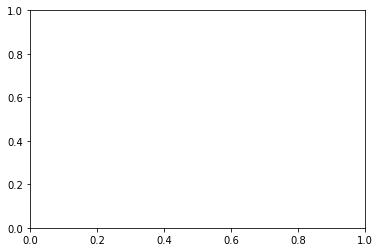

In [24]:
import matplotlib.pyplot as plt
import pickle
import numpy as np

fig, axs = plt.subplots()

"""
Coupled_FL
"""
# diversity 0
with open('../coupled_0.00.pkl', 'rb') as f:
    global_acc, global_loss, local_acc, local_loss = pickle.load(f)

# y = local_acc
# x = np.arange(len(y))
# axs.plot(x,y,label='Diversity 0 (Coupled_FL)', linestyle='-')

In [25]:
x = np.arange(len(local_acc), step=5)
y = [local_acc[i] for i in x]

In [30]:
y = [local_acc[i] for i in x]


In [29]:
local_acc

[0.8593673772559421,
 0.9002571284924226,
 0.8764298642533938,
 0.9212747790751756,
 0.8477434717387211,
 0.8210246072010777,
 0.8247090643196717,
 0.8349507633577776,
 0.8354799448917095,
 0.8302937694114163,
 0.8446414488414398,
 0.8690529579353109,
 0.8512957855361435,
 0.8380818980292866,
 0.8596983853689645,
 0.8573887599636768,
 0.8025497378438555,
 0.8652922220753103,
 0.8982947902767213,
 0.8375867269984918,
 0.8613081155081064,
 0.8306917918682626,
 0.8438656442593399,
 0.885344745154956,
 0.8373887762001353,
 0.8134684168264219,
 0.8180655867949895,
 0.7859316125484319,
 0.8211954559601619,
 0.8008853813794898,
 0.7770956326117258,
 0.8382804588149344,
 0.8743819203109263,
 0.8004883151415859,
 0.8332063847408604,
 0.7570189853719265,
 0.8772148506085463,
 0.8058270237387883,
 0.7871870731517701,
 0.8137930685666536,
 0.8130544244026151,
 0.8238590343480048,
 0.8159490291843234,
 0.8323317205670147,
 0.888599392029539,
 0.7729330576158071,
 0.8062389020981222,
 0.864356370686